In [21]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# Chargement  des données 

In [22]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [23]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.3)
val,test = train_test_split(test,  test_size=0.5)


In [24]:
hist

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2014-12-21,322.63,332.03,320.13,330.35,20668.93,6.746131e+06
2014-12-22,330.84,335.26,319.89,322.63,35363.79,1.169469e+07
2014-12-23,335.25,339.32,328.00,330.84,24066.78,8.057503e+06
2014-12-24,322.40,336.28,320.65,335.25,21524.09,7.112691e+06
2014-12-25,318.99,323.38,316.30,322.40,15388.54,4.926116e+06
...,...,...,...,...,...,...
2020-06-08,9782.58,9801.19,9658.72,9750.70,32766.08,3.186063e+08
2020-06-09,9779.70,9884.83,9604.13,9782.58,38753.41,3.768165e+08
2020-06-10,9891.84,9990.40,9708.63,9779.70,40206.35,3.950059e+08


# Séparation data en 3 set : Apprentisage, validation, test 

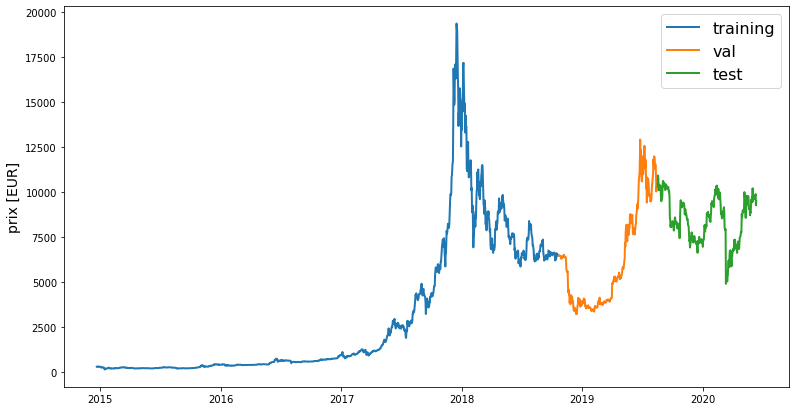

In [25]:
def line_plot(line1, line2,line3= None, label1=None, label2=None,label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('prix [EUR]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    plt.savefig('donnees.png')
line_plot(train[target_col],val[target_col], test[target_col], 'training', 'val','test', title='')

# Data cleanning et préparation 

In [26]:
#normalisation par rapport à la base 0
#permet de mettre toute les valeur sur une base commune.
def normalise(df):
    return df / df.iloc[0] - 1

In [27]:
#Extraction des données par fenêtres de taille "window_len", pour un apprentissage par groupe.
def extract_window_data(df, window_len):
    window_data = []
    for indice in range(len(df) - window_len):
        temp = df[indice: (indice + window_len)].copy()
        temp = normalise(temp)
        #copi des valeur de temp dans windows_data
        window_data.append(temp.values)
    return np.array(window_data)

In [28]:
#Préparation des données pour l'apprentissage
#Séparation en 3 ensembles, préparation des vecteurs de features et targets
def prepare_data(df, target_col, window_len=10, val_size=0.2,test_size=0.5):
    train_data, test_data = train_test_split(df, test_size=val_size)
    val_data, test_data =train_test_split(test_data, test_size=test_size)
    X_train = extract_window_data(train_data, window_len)
    X_val = extract_window_data(val_data, window_len)
    X_test = extract_window_data(test_data, window_len)
    y_train = train_data[target_col][window_len:].values/ train_data[target_col][:-window_len].values - 1
    y_val = val_data[target_col][window_len:].values/ val_data[target_col][:-window_len].values - 1
    y_test = test_data[target_col][window_len:].values/ test_data[target_col][:-window_len].values - 1
  
    return train_data,val_data, test_data, X_train,X_val, X_test, y_train,y_val, y_test

# Construction du model 

In [29]:
#Construction du model avec la bibliothéque KERAS 
#La fonction est générique et ne fixe que la structure du réseau
#Le nombre de neurones, le droupout, ect restent paramétrables. 
def build_lstm_model(input_data, output_size, neurons, activ_func, dropout, loss, optimizer):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

# Apprentissage

In [30]:
#Hyper-paramètres utilisé pour la prédiction 
np.random.seed(10)
window_len = 10
val_size = 0.3
test_size = 0.5 #la moitier de l'embre de validation donc 0.15 de l'ensemble total
activ_func = 'linear'
lstm_neurons = 20
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.5
optimizer = 'adam'


In [31]:
#Préparation,Constuction et entrainement (.fit) du model 
train,val, test, X_train,X_val, X_test, y_train,y_val, y_test = prepare_data(hist, target_col, window_len=window_len,val_size=val_size, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, activ_func=activ_func,dropout=dropout, loss=loss,optimizer=optimizer)
fit = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_data = (X_val,y_val))


Train on 1391 samples, validate on 290 samples
Epoch 1/20
1391/1391 [==============================] - 0s 348us/step - loss: 0.0347 - val_loss: 0.0088
Epoch 2/20
1391/1391 [==============================] - 0s 133us/step - loss: 0.0171 - val_loss: 0.0068
Epoch 3/20
1391/1391 [==============================] - 0s 132us/step - loss: 0.0126 - val_loss: 0.0059
Epoch 4/20
1391/1391 [==============================] - 0s 126us/step - loss: 0.0098 - val_loss: 0.0053
Epoch 5/20
1391/1391 [==============================] - 0s 130us/step - loss: 0.0076 - val_loss: 0.0048
Epoch 6/20
1391/1391 [==============================] - 0s 133us/step - loss: 0.0069 - val_loss: 0.0045
Epoch 7/20
1391/1391 [==============================] - 0s 134us/step - loss: 0.0059 - val_loss: 0.0043
Epoch 8/20
1391/1391 [==============================] - 0s 134us/step - loss: 0.0059 - val_loss: 0.0041
Epoch 9/20
1391/1391 [==============================] - 0s 135us/step - loss: 0.0051 - val_loss: 0.0038
Epoch 10/20
1391/

In [13]:
model.summary()
result=model.evaluate(X_test,y_test, batch_size=batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
290/290 [==============================] - 0s 45us/step


# Test


In [14]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)


0.03327096576601771

In [15]:
preds = test[target_col].values[:-window_len] * (preds+1 )
preds = pd.Series(index=targets.index, data=preds)


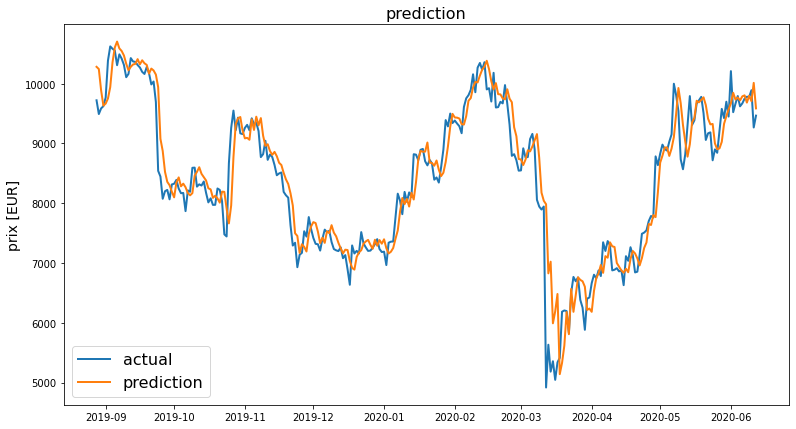

In [16]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(targets, label='actual', linewidth=2)
ax.plot(preds, label='prediction', linewidth=2)
ax.set_ylabel('prix [EUR]', fontsize=14)
ax.set_title('prediction', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.savefig('prediction.png')
plt.show()
